<a href="https://colab.research.google.com/github/xphoenix102/wpi-lab8/blob/master/Copy_of_lab5_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elementy Inteligencji Obliczeniowej (EIO)


---



Prowadzący: Jakub Bednarek

Kontakt: jakub.bednarek@put.poznan.pl

Materiały: [Strona WWW](http://jakub.bednarek.pracownik.put.poznan.pl)


---


## Cel ćwiczeń: 

* Implementacja nowoczesnych warstw sieci neuronowych,
* poznanie modeli typu autoenkoder.


**UWAGA**: W Colabie pojawiła się możliwość korzystania z jednostek TPU. Z tego względu domyślnie wyłączone zostało korzystanie z GPU. Aby włączyć GPU (lub TPU) należy wejść do **Edit -> Notebook Settings i wybrać Hardware Accelerator**.

---

Poniżej znajduje się kod do wczytania danych z datasetu CIFAR 10 oraz MNIST:

In [0]:
import keras
from keras.datasets import cifar10, mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from skimage import color

batch_size = 200
salt_ratio = .05
pepper_ratio = .15


def get_ds(x, y, f):
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(x.shape[0])
  ds = ds.batch(batch_size)
  it = ds.make_initializable_iterator()
  (images, labels) = it.get_next()
  images = tf.image.convert_image_dtype(images, tf.float32)
  
  if len(images.get_shape()) <= 3:
    images = tf.expand_dims(images, 3)
  additional = f(images)
  return it, (additional, labels, images)

def noise(img):
  random = tf.random_uniform(shape=tf.shape(img), minval=0.0, maxval=1.0)
  salt = tf.to_float(tf.greater_equal(random, 1.0 - salt_ratio))
  pepper = tf.to_float(tf.greater_equal(random, pepper_ratio))
  return tf.minimum(tf.maximum(img, salt), pepper)

def grayscale(img):
  return tf.image.rgb_to_grayscale(img)

def gr(img):
  return img

def get_mnist():
  train, test = mnist.load_data()
  return get_ds(*train, noise), get_ds(*test, noise)

def get_cifar10():
  train, test = cifar10.load_data()
  return get_ds(*train, grayscale), get_ds(*test, grayscale)

(?, 32, 32, 3)


### Nowoczesne warstwy sieci neuronowych

Obecnie trwają bardzo intensywne prace nad skomplikowanymi sieciami neuronowymi realizującymi złożone zadania jak segmentacja semantyczna, sterowanie robotami czy prowadzenie i zarządzanie autonomicznymi pojazdami. Istnieje wiele nurtów rozwoju w tym kierunku, jednym z nich jest opisywanie świata w sposób bardzo probabilistyczny. Innym jest próba konstruowania warstw neuronowych, rozwiązujących poszczególne, prostsze problemy - nimi będziemy się zajmować na tych laboratoriach.

#### ResNet

Pierwszą z omawianych warstw jest tzw. *residual layer*, która została stworzona aby zminimalizować problem zaniku gradientu podczas jego propagacji. Idea polega na tworzeniu *skip-connection* pomiędzy wejściem na warstwę a pewną sekwencją operacji na danych (jak np. konwolucja). Warstwa ta pierwotnie została zaprezentowana w wielu wariantach przez zespół naukowy z Microsoft ich artykule: [link](https://arxiv.org/pdf/1603.05027.pdf).

![alt text](http://www.jakub.bednarek.pracownik.put.poznan.pl/wp-content/uploads/2018/11/Zrzut-ekranu-z-2018-11-13-19-34-07.png)

**weight** oznacza fully-connected / convolution lub inną operacją liniową,
**BN** - batch normalization.


Na jej podstawie powstało wiele innych architektur korzystających z *residual layers* np. wykorzystywana w robotyce sieć [ERFNet](http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera17tits.pdf). Dzięki zastąpieniu filtrów n x n w konwolucji przez dwie konwolucje z filtrami 1 x n oraz n x 1 udało się zredukować liczbę parametrów modelu o 1/3 przez co czas inferencji znacząco spadł i obecnie nie ma problemu z wykorzystaniem takiej sieci w czasie rzeczywistym.

![alt text](http://www.jakub.bednarek.pracownik.put.poznan.pl/wp-content/uploads/2018/11/Zrzut-ekranu-z-2018-11-13-19-43-24.png)

## Zadanie 1

Zaimplementuj wybraną warstwę residual z wykorzystaniem konwolucji.

In [44]:
def residual(x, in_f, momentum, activation, training):
  
    model = tf.layers.batch_normalization(x, momentum=momentum, training=training)
    model = tf.nn.relu(model)    
    model = tf.layers.conv2d(model,filters = in_f, kernel_size= [3,3], padding='same', activation=activation)
    
    model = tf.layers.batch_normalization(model, momentum=momentum, training=training)
    model = tf.nn.relu(model)
    model = tf.layers.conv2d(model,filters = in_f, kernel_size= [4,4], padding='same', activation=activation)
    model = x + model
    return  model
  
  
input_data = tf.random_normal([3, 128, 128, 32], dtype=tf.float32)
out = residual(input_data,32,0.9,tf.nn.relu,True)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

print('Rozmiar tensora: ', sess.run(tf.shape(out)))

Rozmiar tensora:  [  3 128 128  32]


#### Downsample

Innym zagadnieniem są operacje zmniejszania wymiarowości danych wejściowych. Zazwyczaj warstwy takie korzystają z konwolucji i/lub poolingu z odpowiednim stride. Poniżej przedstawione zostały 2 proste opisy takich bloków:

![alt text](http://www.jakub.bednarek.pracownik.put.poznan.pl/wp-content/uploads/2018/11/downsample-1.png)

Pierwszy przypadek to znany z poprzednich zajęć schemat, w którym redukujemy wymiarowość stosująć pooling z danym argumentem **stride**. Drugi przypadek polega na równoległym wykonaniu operacji konwolucji oraz max-poolingu (zwróć uwagę, że max pooling jest wykonywany na wejściu - czy wiesz dlaczego?). Następnie produkty obu operacji są konkatenowane, "przepuszczane" przez Batch Normalization i **dopiero** przez funkcję aktywacji. Co jest bardzo ważne: metoda ta służy do zmniejszania wymiarowości **na rzecz liczby filtrów**. Przykład: input posiada 16 kanałów - rezultatem poolingu jest również obraz z 16 kanałami. W momencie gdy chcemy mieć 64 kanały na wyjściu konwolucja powinna posiadać ich **64 - 16 (generalnie out_f - in_f)**.

## Zadanie 2

Zaimplementuj drugi omówiony scenariusz operacji downsamplingu.



In [45]:
def downsample(x, in_f, out_f, momentum, activation, training):
    #print(out_f-in_f)
    model1 = tf.layers.conv2d(inputs = x,filters = out_f-in_f, kernel_size= [3,3], strides=2, padding='same', activation=activation) 
    
    model2 = tf.layers.max_pooling2d(inputs = x, pool_size=[2, 2], strides=2)
    #print(np.shape(model1),np.shape(model2))
    model = tf.concat([model1,model2], 3)
    
    model = tf.layers.batch_normalization(model, momentum=momentum, training=training)
    model = tf.nn.relu(model)
    return model
  
input_data = tf.random_normal([3,32, 32, 3], dtype=tf.float32)
out = downsample(input_data,3,16,0.9,tf.nn.relu,True)
out = downsample(out,16,32,0.9,tf.nn.relu,True)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

print('Rozmiar tensora: ', sess.run(tf.shape(out)))

Rozmiar tensora:  [ 3  8  8 32]


#### Upsampling

Ostatnią z wprowadzanych dzisiaj rodzajów warstw jest warstwa upsamplingu. Podobnie jak w przypadku downsamplingu przyjęło się stosowanie jednej z dwóch operacji zwiększania wymiarowości:

* konwolucja transponowana (wraz z Batch Normalization),
* bilinear sampling.

Obie metody są bardzo proste do zastosowania w Tensorflow:

In [0]:
def upsample_conv(x, f, if_batch_norm, activation, training):
  up = tf.layers.conv2d_transpose(x, f, [5,5], 2, 'SAME')
  if if_batch_norm:
    up = tf.layers.batch_normalization(up, epsilon=1e-8, training=training)
  return activation(up) if activation is not None else up

def updample_bilinear(x, out_size):
  # out_size takes values like [height, width], without 3rd value for channels
  return tf.image.resize_bilinear(x, out_size)

#### Autoenkoder

Korzystając z powyżej przedstawionych operacji jesteśmy w stanie stworzyć autoenkoder - model neuronowy, który na wyjściu stara się odtworzyć dane wejściowe (lub podobne do wejściowych). Przykładem takiej sieci może być sieć do usuwania szumu lub sieć do kolorowania czarnobiałych zdjęć.

Więcej o autoenkoderach: [link 1](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798), [link 2](http://machinelearninguru.com/deep_learning/tensorflow/neural_networks/autoencoder/autoencoder.html)

Autoenkodery charakteryzują się specyficzną budową, która polega na zredukowaniu danych wejściowych do pewnej reprezentacji nazywanej **latent representation**, a następnie na odbudowaniu z nich danych wejściowych. W ten sposób definiujemy strukturę autoenkodera jako **enkoder - dekoder**. Dekoder zajmuje się "zwijaniem" danych do pewnej gęstszej reprezentacji (o zazwyczaj mniejszej wymiarowości), natomiast dekoder dekoduje dane wejściowe z ukrytej reprezentacji (latent representation).

## Zadanie 3 
Uzypełnik kod w taki sposób, aby uzyskać strukturę autoenkodera w zastosowaniu do odfiltrowania danych wejściowych.

In [0]:
(train_iterator, (x_train, _, gt_train)), (test_iterator, (x_test, _, gt_test)) = get_cifar10()
print(x_train.shape)

170500096/170498071 [==============================] - 30s 0us/step
(?, 32, 32, 1)


11493376/11490434 [==============================] - 2s 0us/step
Total epoch 0 loss: 0.020657372726127506
Total epoch 1 loss: 0.009909323851267497
Total epoch 2 loss: 0.008856458915397524
Total epoch 3 loss: 0.008075156494354209
Total epoch 4 loss: 0.00705907477842023
Total epoch 5 loss: 0.006627167415184279
Total epoch 6 loss: 0.006323014061587552
Total epoch 7 loss: 0.006233840864151716
Total epoch 8 loss: 0.006050591724924743
Total epoch 9 loss: 0.005945771895349026


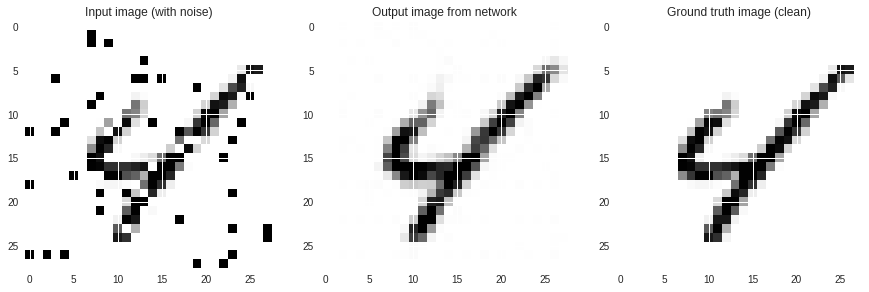

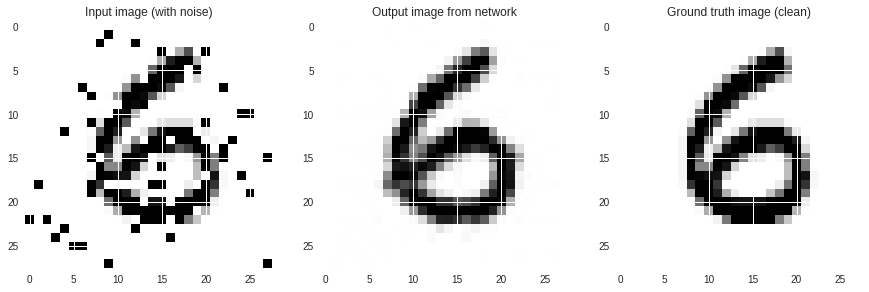

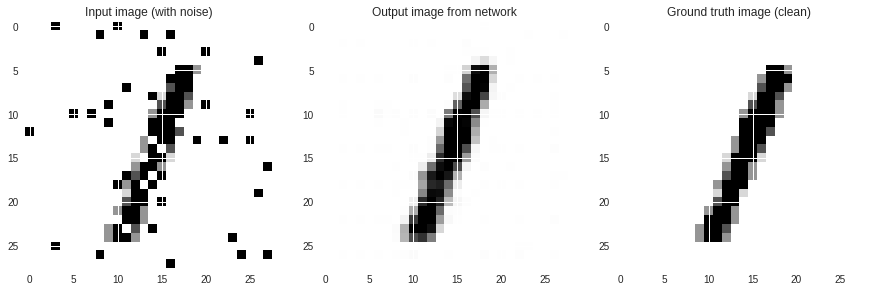

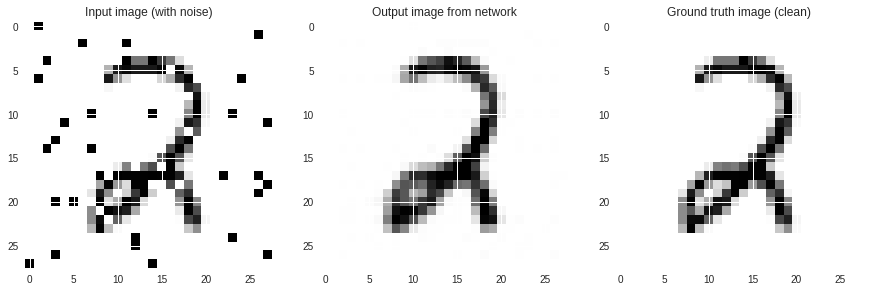

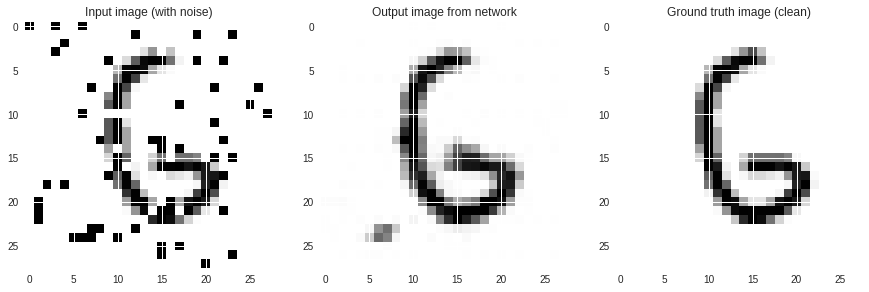

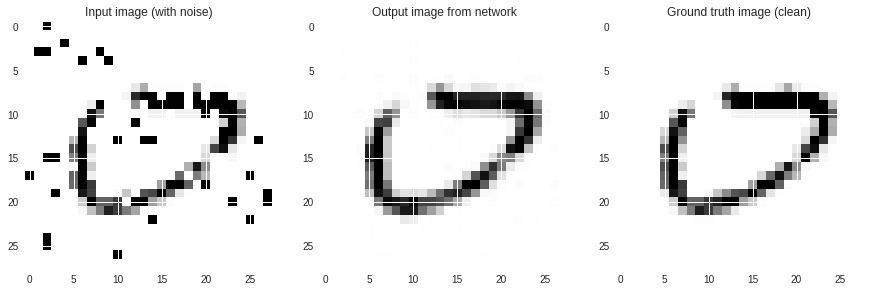

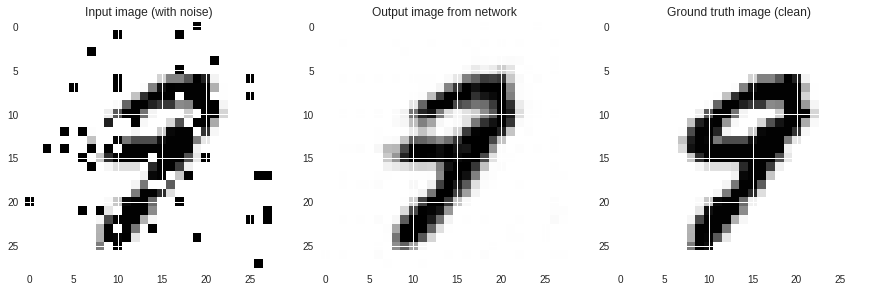

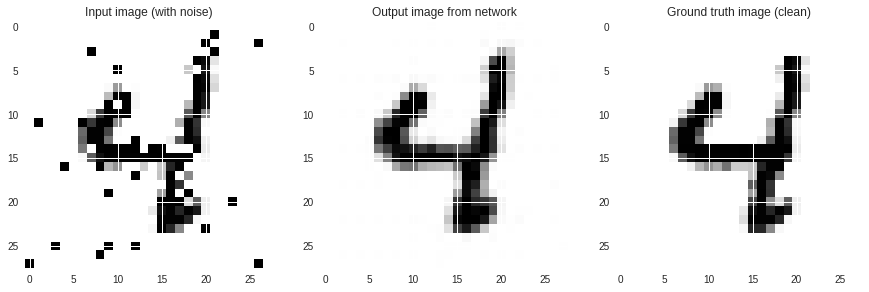

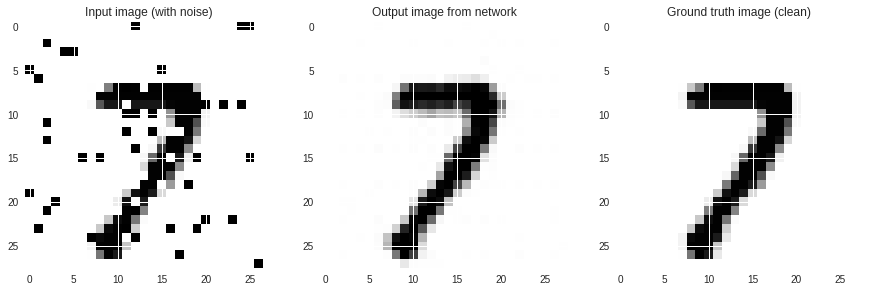

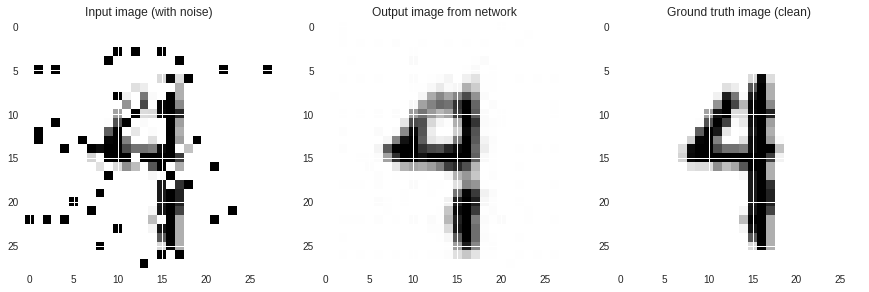

In [0]:
tf.reset_default_graph()

def model(in_image, training):
  with tf.variable_scope('denoise', reuse=tf.AUTO_REUSE):
    layer = downsample(in_image , 1,16, 0.8, tf.nn.relu, training)
    layer = downsample(layer , 16,32, 0.8, tf.nn.relu, training)
    layer = upsample_conv(layer, 16, True, activation=tf.nn.relu, training=training)
    layer = upsample_conv(layer, 1, False, activation=None, training=training)
    return layer
    
def train(sess, iterator, train_op, loss, num_epochs):
  for i in range(num_epochs):
    sess.run(iterator.initializer)
    total_loss = []
    while True:
      try:
        _, l = sess.run([train_op, loss])
        total_loss.append(l)
      except tf.errors.OutOfRangeError:
        break
    print('Total epoch {0} loss: {1}'.format(i, sum(total_loss) / len(total_loss)))

def test(sess, iterator, img_in, img_out, img_gt):
  sess.run(iterator.initializer)
  try:
    o_img_in, o_img_out, o_img_gt = sess.run([img_in, img_out, img_gt])
    
    for i in range(10):
      fig = plt.figure(figsize=(15, 5))
      
      ax = fig.add_subplot(131)
      ax.imshow(o_img_in[i, :, :, 0])
      ax.set_title("Input image (with noise)")

      ax = fig.add_subplot(132)
      ax.imshow(o_img_out[i, :, :, 0])
      ax.set_title("Output image from network")

      ax = fig.add_subplot(133)
      ax.imshow(o_img_gt[i, :, :, 0])
      ax.set_title("Ground truth image (clean)")
  except tf.errors.OutOfRangeError:
    return

(train_iterator, (x_train, _, gt_train)), (test_iterator, (x_test, _, gt_test)) = get_mnist()

train_output = model(x_train, True)
test_output = model(x_test, False)
test_output = tf.clip_by_value(test_output, 0, 1)

loss = tf.losses.mean_squared_error(gt_train, train_output)

optimizer = tf.train.AdamOptimizer(0.01)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
  train_op = optimizer.minimize(loss)

    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

num_epochs = 10

train(sess, train_iterator, train_op, loss, num_epochs)
test(sess, test_iterator, x_test, test_output, gt_test)



## Projekt 2

Wykorzystując stworzone powyżej warstwy oraz korzystając z wiedzy z poprzednich zajęć stwórz autoenkoder do kolorowania zdjęć czarno-białych. W funkcjach pomocniczych zostało zaimplementowane pobieranie i korzystanie z danych z datasetu CIFAR 10 w podobny sposób co w przypadku MNIST. Możesz wykorzystać ten dataset lub samemu/samej wybrać interesujący zbiór obrazów (np. podzbiór ImageNet, albo wyszukać jakiś prosty dataset w google - celem tego zadania nie są olbrzymie obliczenia, lecz weryfikacja zrozumienia tematu sieci neuronowych).

**Uwagi:**
* W przypadku wybrania własnego zbioru danych rozwiązanie należy przesłać razem ze skryptem ściągającym dane i ładującym go do modelu,
* Wybierając inny dataset należy w podobny sposób co powyżej stworzyć obrazy grayscale,
* Wejściem sieci powinny być obrazy Grayscale a wyjściem RGB,
* Polecaną funkcją straty jest Mean Square Error,
* Skrypt powinien, podobnie jak powyżej, podczas testowania zaprezentować wynik działania,
* Skrypt powinien stworzyć wykres funkcji straty podczas uczenia.
* Projekty można wykonać w Colab (proszę pamiętać, aby włączyć GPU w ustawieniach) lub w zwykłym skrypcie,
* Jeśli projekt zostanie wykonany w skrypcie proszę dołączyć readme, w którym będzie zawarte jak go wywołać (np. jakie parametry podać), oraz proszę zamieścić informację **mniej więcej jak długo uczył się model**.

**Co będzie oceniane:**
* korzystanie z poznanych technik sieci neuronowych,
* **mądre** dobranie hiperparametrów jak rozmiar sieci, prędkość uczenia itp. (zalecam eksperymentowanie z modelem),
* znajomość technik regularyzacji,
* znajomość poprawnego definiowania modelu dla trenowania i testowania,
* odpowiedź na ewentualne pytania zadane przy oddawaniu projektu.

**Termin oddania projektu: czas na wykonanie projektu to tydzień, jednak ze względu na przesunięcie labów grupy popołudniowej termin oddawania to 28 listopada 2018 dla obu grup. Są to też ostatnie zajęcia, dlatego nie będzie możliwości poprawiania projektu.**

In [0]:
def t():
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  (train_iterator, (x_train, _, gt_train)), (test_iterator, (x_test, _, gt_test)) = get_cifar10()
  sess.run(train_iterator.initializer)
  sess.run(test_iterator.initializer)
  try:
    o_img_in,  o_img_gt = sess.run([x_test,  gt_test])
  
    for i in range(10):
      o_img =  tf.image.rgb_to_hsv(o_img_gt[i,:,:,:])
     # o_img = o_img.as_type('float32')
      fig = plt.figure(figsize=(15, 5))
      
      ax = fig.add_subplot(151)
     
      ax.imshow(o_img_in[i, :, :,0]) 
      ax.set_title("Input image (with noise)")

#       ax = fig.add_subplot(152)    
#       ax.imshow(o_img[ :,:, 0])      
#       ax.set_title("Output image from network")
      
#       ax = fig.add_subplot(153)
#       ax.imshow(o_img[ :,:, 1])
#       ax.set_title("Output image from network")
      
#       ax = fig.add_subplot(154)
#       ax.imshow(o_img[ :,:, 2])
#       ax.set_title("Output image from network")

      ax = fig.add_subplot(155)
      ax.imshow(sess.run(tf.clip_by_value(tf.image.hsv_to_rgb(o_img), 0, 1)) )
      ax.set_title("Output image from network")
      
      fig.show()
  except tf.errors.OutOfRangeError:
    print('error')
t()


#https://arxiv.org/pdf/1603.06668.pdf
#http://tinyclouds.org/colorize/
#https://www.reddit.com/r/pytorch/comments/9ibnzx/looking_for_a_simple_example_of_a_autoencoder/
#https://github.com/jaxony/unet-pytorch

Total epoch 0 loss: 0.040939264874905346
Total epoch 1 loss: 0.012453049540519715
Total epoch 2 loss: 0.009331491297110915
Total epoch 3 loss: 0.008048654979094863
Total epoch 4 loss: 0.007361593902111054
Total epoch 5 loss: 0.006908558744937182
Total epoch 6 loss: 0.006521667400375008
Total epoch 7 loss: 0.006240432158112526
Total epoch 8 loss: 0.006000802807509899
Total epoch 9 loss: 0.005861170127987861
Total epoch 10 loss: 0.005583537016063928
Total epoch 11 loss: 0.005373197821900249
Total epoch 12 loss: 0.005272247416898608
Total epoch 13 loss: 0.004936866546981037
Total epoch 14 loss: 0.004781332449987531
Total epoch 15 loss: 0.004467834017239511
Total epoch 16 loss: 0.0043417053213343024
Total epoch 17 loss: 0.004131366751156747
Total epoch 18 loss: 0.003978816416114569
Total epoch 19 loss: 0.003937625034712255


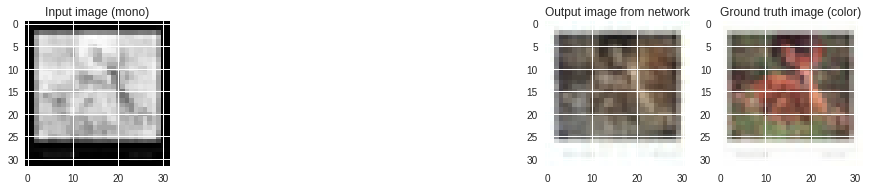

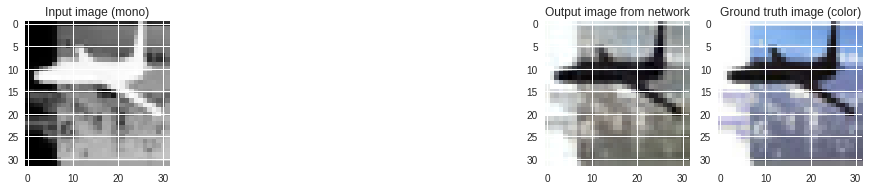

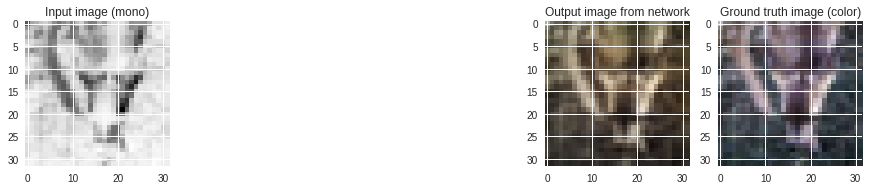

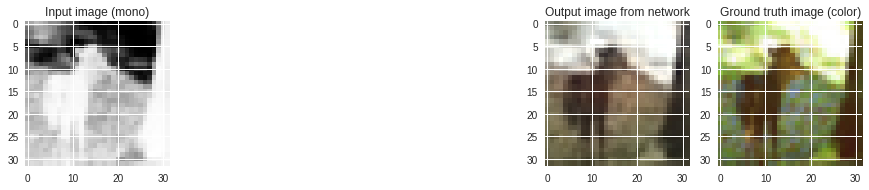

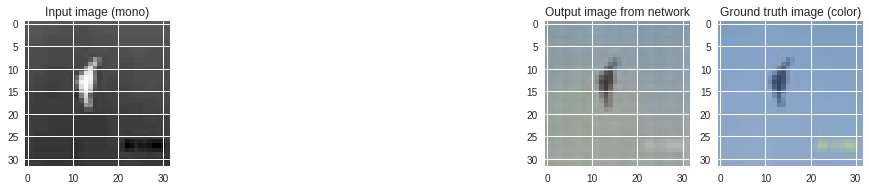

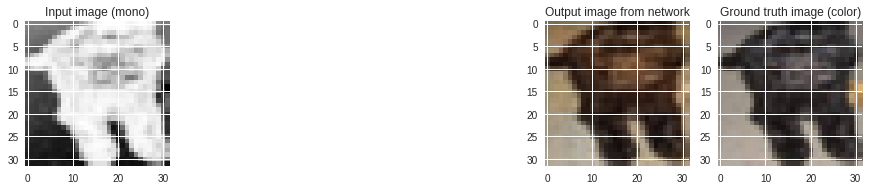

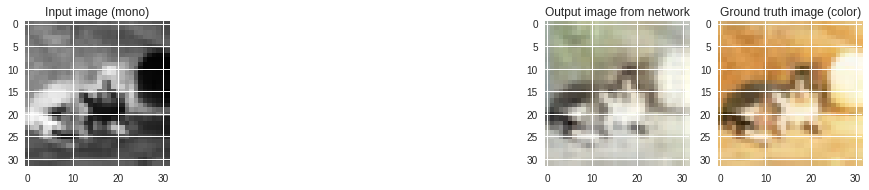

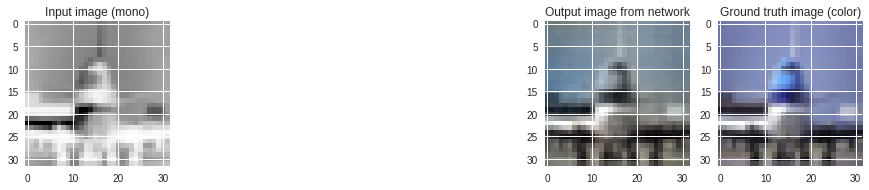

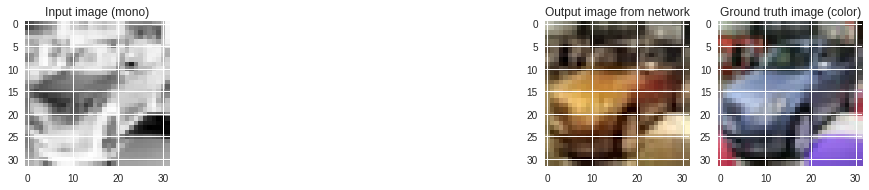

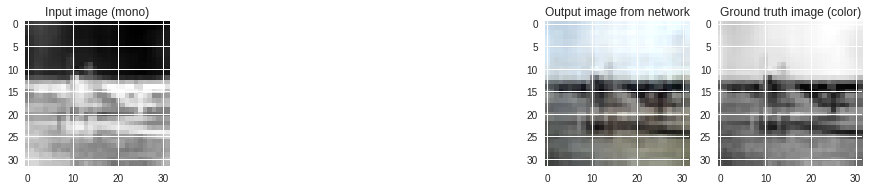

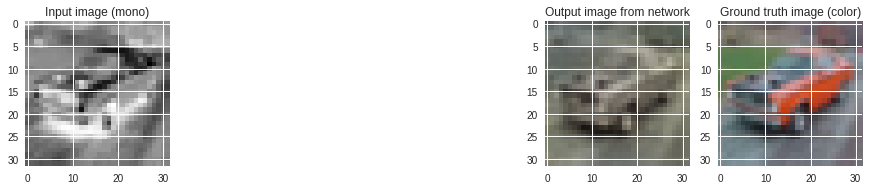

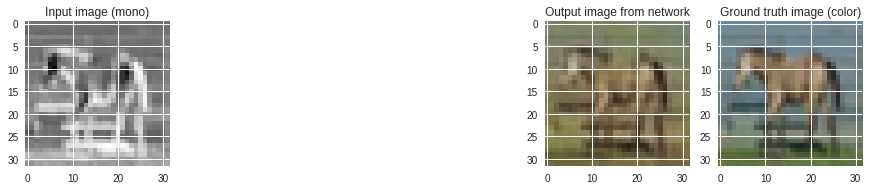

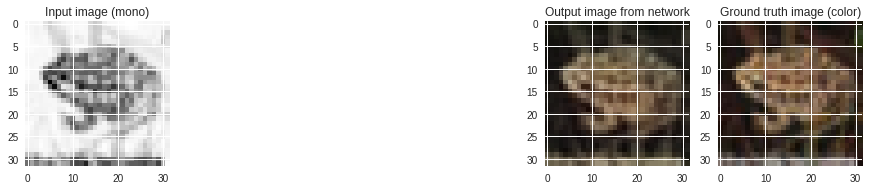

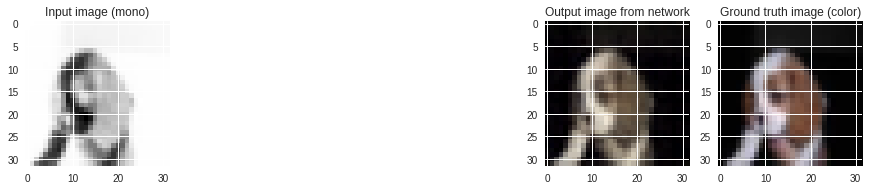

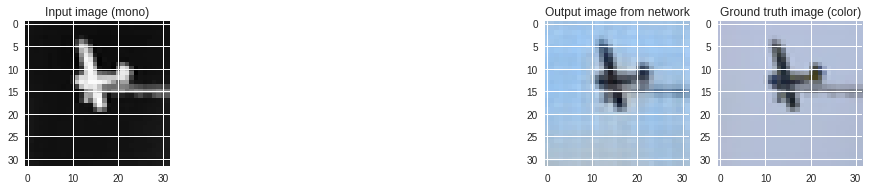

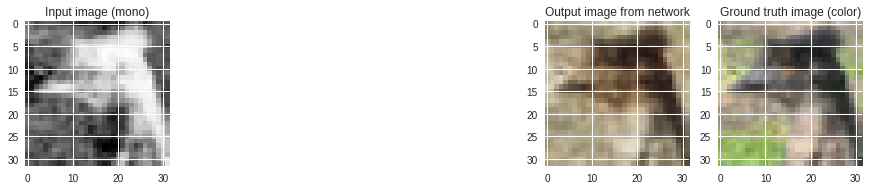

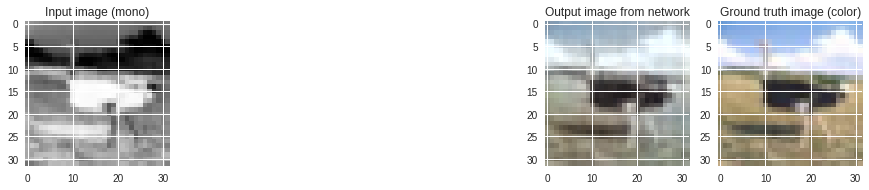

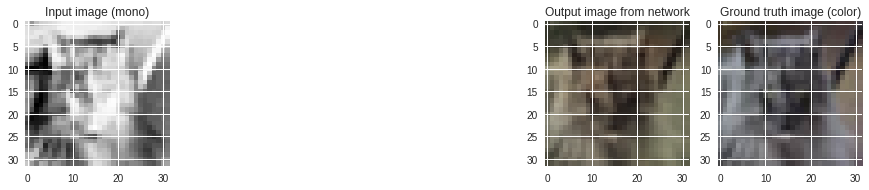

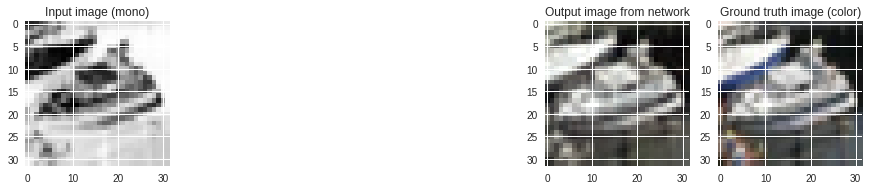

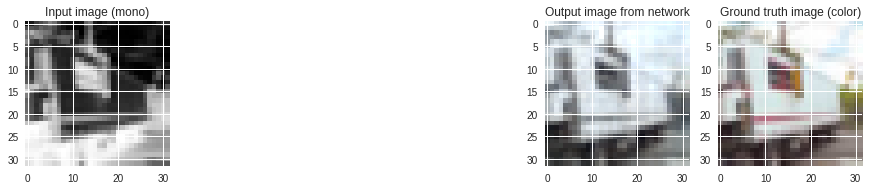

In [68]:
tf.reset_default_graph()

def model(in_image, training):
  with tf.variable_scope('colorize', reuse=tf.AUTO_REUSE, regularizer=tf.contrib.layers.l2_regularizer(2e-4)):

    
 
    res1= tf.layers.conv2d(in_image,filters = 64, kernel_size= [1,1], strides=2, padding='same', activation=None)
    res1 = tf.layers.batch_normalization(res1, momentum=0.8, training=training)
    layer = downsample(in_image , 1,64, 0.8, tf.nn.relu, training) 
    layer = layer+res1
    
    res2= tf.layers.conv2d(layer,filters = 128, kernel_size= [1,1], strides=2, padding='same', activation=None)
    res2 = tf.layers.batch_normalization(res2, momentum=0.8, training=training)
    layer = downsample(layer , 64,128, 0.8, tf.nn.relu, training) 
    layer = layer+res2
    
    res3= tf.layers.conv2d(layer,filters = 256, kernel_size= [1,1], strides=2, padding='same', activation=None)
    res3 = tf.layers.batch_normalization(res3, momentum=0.8, training=training)
    layer = downsample(layer , 128,256, 0.9, tf.nn.relu, training) 
    layer = layer+res3
    

    layer = residual(layer, 256, 0.8, tf.nn.relu, training)
    
    #layer = tf.concat([layer,shortcut], 3)
    #layer = tf.layers.conv2d(layer,filters = 256, kernel_size= [1,1], padding='same', activation=tf.nn.relu)
    
    #layer = downsample(layer , 80,200, 0.8, tf.nn.relu, training)
   # layer = residual(layer, 32, 0.9, tf.nn.relu, training)

#     layer = downsample(layer , 32,64, 0.8, tf.nn.relu, training)

    layer = upsample_conv(layer, 128, True, activation=tf.nn.relu, training=training)
    layer = upsample_conv(layer, 64, True, activation=tf.nn.relu, training=training)
    #layer = tf.layers.batch_normalization(layer, momentum=0.9, training=training)
    layer = upsample_conv(layer, 3, False, activation=None, training=training)
    return layer
    
def train(sess, iterator, train_op, loss, num_epochs):
  for i in range(num_epochs):
    sess.run(iterator.initializer)
    total_loss = []
    while True:
      try:
        _, l = sess.run([train_op, loss])
        total_loss.append(l)
      except tf.errors.OutOfRangeError:
        break
    print('Total epoch {0} loss: {1}'.format(i, sum(total_loss) / len(total_loss)))
   # print(i)
    
def test(sess, iterator, img_in, img_out, img_gt):
  sess.run(iterator.initializer)
  try:
    o_img_in, o_img_out, o_img_gt = sess.run([img_in, img_out, img_gt])
    
    for i in range(20):
      fig = plt.figure(figsize=(15, 5))
      #print(metrics.mean_squared_error(o_img_out[i, :, :], o_img_gt[i, :, :]))
      #print("r",sess.run(tf.losses.mean_squared_error(o_img_out[i, :, :,  0], o_img_gt[i, :, 0])))
      #print("g",sess.run(tf.losses.mean_squared_error(o_img_out[i, :, 1], o_img_gt[i, :, 1])))
     # print("b",sess.run(tf.losses.mean_squared_error(o_img_out[i, :, 2], o_img_gt[i, :, 2])))
      
      #print(sess.run(tf.losses.mean_squared_error(o_img_out[i, :, :, :], o_img_gt[i, :,:, :])))
      
      o_img_out2 = sess.run(tf.clip_by_value(tf.image.hsv_to_rgb(o_img_out[i, :,:, :]), 0, 1)) 
      o_img_gt2= sess.run(tf.clip_by_value(tf.image.hsv_to_rgb(o_img_gt[i, :,:, :]), 0, 1)) 
      
      o_img_out2 = o_img_out[i, :,:, :]
      o_img_gt2= o_img_gt[i, :,:, :]
      
      ax = fig.add_subplot(151)
      ax.imshow(o_img_in[i, :, :,0])
      ax.set_title("Input image (mono)")

#       ax = fig.add_subplot(152)    
#       ax.imshow(o_img_out2[ :,:, 0])      
#       ax.set_title("Output image from network")
      
#       ax = fig.add_subplot(153)
#       ax.imshow(o_img_out2[ :,:, 1])
#       ax.set_title("Output image from network")
      
      ax = fig.add_subplot(154)
      ax.imshow(o_img_out2[ :,:, :])
      ax.set_title("Output image from network")

      ax = fig.add_subplot(155)
      ax.imshow(o_img_gt2[ :, : , :])
      ax.set_title("Ground truth image (color)")
      

      
  except tf.errors.OutOfRangeError:
    return
#RGB
(train_iterator, (x_train, _, gt_train)), (test_iterator, (x_test, _, gt_test)) = get_cifar10()

#hsv
#(train_iterator, (x_train, _, gt_train)), (test_iterator, (x_test, _, gt_test)) = get_cifar10()
#gt_train = tf.image.rgb_to_hsv(gt_train)
#gt_test = tf.image.rgb_to_hsv(gt_test)


train_output = model(x_train, True)
test_output = model(x_test, False)

test_output = tf.clip_by_value(test_output, 0, 1)

#loss = tf.losses.mean_squared_error(gt_train[:,:, :, 1], train_output[:,:, :, 1]) + tf.losses.mean_squared_error(gt_train[:,:, :, 0], train_output[:,:, :, 0]) + tf.losses.mean_squared_error(gt_train[:,:, :, 2], train_output[:,:, :, 2])
loss =tf.losses.mean_squared_error(gt_train, train_output)
#loss = (1-tf.image.ssim(gt_train,train_output,1.0))*0.2+tf.losses.mean_squared_error(gt_train, train_output)*0.8


optimizer = tf.train.AdamOptimizer(0.007)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
  train_op = optimizer.minimize(loss)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

num_epochs = 20

train(sess, train_iterator, train_op, loss, num_epochs)
test(sess, test_iterator, x_test, test_output, gt_test)

In [0]:
    shortcut = tf.layers.batch_normalization(in_image, momentum=0.9, training=training)
    shortcut = tf.nn.relu(shortcut)    
    shortcut = tf.layers.conv2d(shortcut,filters = 128, kernel_size= [4,4], strides=2, padding='same', activation=tf.nn.relu)
    
    shortcut = tf.layers.batch_normalization(shortcut, momentum=0.9, training=training)
    shortcut = tf.nn.relu(shortcut)    
    shortcut = tf.layers.conv2d(shortcut,filters = 256, kernel_size= [3,3], strides=2, padding='same', activation=tf.nn.relu)
 
    shortcut = tf.layers.batch_normalization(shortcut, momentum=0.9, training=training)
    shortcut = tf.nn.relu(shortcut)    
    shortcut = tf.layers.conv2d(shortcut,filters = 256, kernel_size= [2,2], strides=2, padding='same', activation=tf.nn.relu)
    
    #layer = residual(in_image, 1, 0.9, tf.nn.relu, training)
    
    res1= tf.layers.conv2d(in_image,filters = 64, kernel_size= [1,1], strides=2, padding='same', activation=None)
    layer = downsample(in_image , 1,64, 0.8, tf.nn.relu, training) 
    layer = layer+res1
    
    res2= tf.layers.conv2d(layer,filters = 128, kernel_size= [1,1], strides=2, padding='same', activation=None)
    layer = downsample(layer , 64,128, 0.8, tf.nn.relu, training) 
    layer = layer+res2
    
    res3= tf.layers.conv2d(layer,filters = 256, kernel_size= [1,1], strides=2, padding='same', activation=None)
    layer = downsample(layer , 128,256, 0.9, tf.nn.relu, training) 
    layer = layer+res3
    
    #layer = residual(layer, 64, 0.8, tf.nn.relu, training)
    
    layer = tf.concat([layer,shortcut], 3)
    layer = tf.layers.conv2d(layer,filters = 256, kernel_size= [1,1], padding='same', activation=tf.nn.relu)
    
    #layer = downsample(layer , 80,200, 0.8, tf.nn.relu, training)
   # layer = residual(layer, 32, 0.9, tf.nn.relu, training)

#     layer = downsample(layer , 32,64, 0.8, tf.nn.relu, training)

    layer = upsample_conv(layer, 128, True, activation=tf.nn.relu, training=training)
    layer = upsample_conv(layer, 64, True, activation=tf.nn.relu, training=training)
    #layer = tf.layers.batch_normalization(layer, momentum=0.9, training=training)
    layer = upsample_conv(layer, 3, False, activation=None, training=training)

In [0]:
    shortcut = tf.layers.batch_normalization(in_image, momentum=0.9, training=training)
    shortcut = tf.nn.relu(shortcut)    
    shortcut = tf.layers.conv2d(shortcut,filters = 128, kernel_size= [3,3], strides=2, padding='same', activation=tf.nn.relu)
    
    shortcut = tf.layers.batch_normalization(shortcut, momentum=0.9, training=training)
    shortcut = tf.nn.relu(shortcut)    
    shortcut = tf.layers.conv2d(shortcut,filters = 128, kernel_size= [2,2], strides=2, padding='same', activation=tf.nn.relu)
    
    
#     shortcut = tf.layers.batch_normalization(shortcut, momentum=0.9, training=training)
#     shortcut = tf.nn.relu(shortcut)    
#     shortcut = tf.layers.conv2d(shortcut,filters = 256, kernel_size= [1,1], strides=2, padding='same', activation=tf.nn.relu)
    
    
    #layer = residual(in_image, 1, 0.9, tf.nn.relu, training)  
    layer = downsample(in_image , 1,64, 0.7, tf.nn.relu, training)    
    #layer = residual(layer, 32, 0.8, tf.nn.relu, training)
    #print(np.shape(layer))
    layer = downsample(layer , 64,128, 0.8, tf.nn.relu, training) 
    #layer = downsample(layer , 128,256, 0.8, tf.nn.relu, training) 
    
    #layer = residual(layer, 64, 0.8, tf.nn.relu, training)
    
    layer = tf.concat([layer,shortcut], 3)
    layer = tf.layers.conv2d(layer,filters = 128, kernel_size= [1,1], padding='same', activation=tf.nn.relu)
    
    #layer = downsample(layer , 80,200, 0.8, tf.nn.relu, training)
   # layer = residual(layer, 32, 0.9, tf.nn.relu, training)

#     layer = downsample(layer , 32,64, 0.8, tf.nn.relu, training)

    #layer = upsample_conv(layer, 64, True, activation=tf.nn.relu, training=training)
    layer = upsample_conv(layer, 64, True, activation=tf.nn.relu, training=training)
    layer = tf.layers.batch_normalization(layer, momentum=0.9, training=training)
    layer = upsample_conv(layer, 3, False, activation=None, training=training)

In [0]:
    layer = downsample(in_image , 1,32, 0.5, tf.nn.relu, training)    

    layer = downsample(layer , 32,64, 0.6, tf.nn.relu, training)    

    
    layer = downsample(layer , 64,128, 0.9, tf.nn.relu, training)    
    layer = residual(layer, 128, 0.9, tf.nn.relu, training)


   # layer = residual(layer, 32, 0.9, tf.nn.relu, training)

    layer = upsample_conv(layer, 64, True, activation=tf.nn.relu, training=training)
    layer = upsample_conv(layer, 32, True, activation=tf.nn.relu, training=training)
    layer = upsample_conv(layer, 3, False, activation=None, training=training)